### Use Case 2: Particles

In this example we will subsample a dataset stored on SciServer using trajectories of synthetic Lagrangian particles.
OceanSpy enables the extraction of properties at any given location, but it does not have functionality to compute Lagrangian trajectories yet.
The trajectories used in this notebook have been previously computed using a Matlab-based Lagrangian particle code ([Gelderloos et al., 2016](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7870923)). The Lagrangian particle code, along with synthetic oceanographic observational platforms (such as Argo floats, isobaric floats, current profiler, and gliders), will be incorporated into OceanSpy in future releases.

The animation below shows the change in temperature of synthetic particles along their 3D trajectories. Particles have been released in Denmark Strait and tracked backward in time from day 0 to day 180, and tracked forward in time from day 180 to 360. All particles are animated forward in time. Source: [https://player.vimeo.com/video/296949375](https://player.vimeo.com/video/296949375)

In [1]:
# Display animation
from IPython.display import HTML

# Link
s = "https://player.vimeo.com/video/296949375"

# Options
w = 640
h = 360
f = 0
a = "autoplay; fullscreen"

# Display
HTML(
    f'<iframe src="{s}"'
    'width="640" height="360" frameborder="0" allow="autoplay; fullscreen"'
    "allowfullscreen></iframe>"
)

/home/idies/mambaforge/envs/Oceanography/lib/python3.9/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


The subsampling method used in this notebook resembles Lagrangian floats deployed by observational oceanographers, such as RAFOS floats. RAFOS floats are isobaric and tracked acoustically. They measure water properties and provide accurate trajectories in both the horizontal and vertical dimensions. The following picture shows the deployment of a RAFOS float during the Overturning in the Subpolar North Atlantic Program (OSNAP). Source: [www.o-snap.org](https://www.o-snap.org/)  
![RAFOS](https://www.o-snap.org/wp-content/uploads/2016/08/160801_deploying_a_RAFOS_float-1-1024x768.jpg)

## Extract
The computational time to extract particle properties depends on the number of particles, the length of their trajectories, the number of variables requested, and, more importantly, how far the particles travel in the domain and therefore, how dispersed the Lagrangian trajectories are.
Thus, it is preferable to extract particle properties asynchronously using the Job mode of SciServer compute (see [SciServer access](sciserver.rst#sciserver-access) for step-by-step instructions).
This notebook, when executed in interactive mode, skips the subsampling step. Instead, it loads an `OceanDataset` previously created executing the same notebook in Job mode. 

Set `interactive = True` to run in Interactive mode, or `interactive = False` to run in Job mode.
Alternatively, you can activate the Job mode by typing `interactive = False` in the **Parameters** slot of the SciServer Job submission form.

In [2]:
interactive = True  # True: Interactive - False: Job

# Check parameters.txt
try:
    # Use values from parameters.txt
    f = open("parameters.txt", "r")
    for line in f:
        exec(line)
    f.close()
except FileNotFoundError:
    # Keep preset values
    pass

The following cell starts a dask client (see the [Dask Client section in the tutorial](Tutorial.ipynb#Dask-Client)).

In [3]:
# Start Client
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40685,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:37562,Total threads: 1
Dashboard: http://127.0.0.1:39030/status,Memory: 25.00 GiB
Nanny: tcp://127.0.0.1:44469,


While the following cell set up the environment.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Additional imports
import xarray as xr
from cartopy.crs import PlateCarree

# Import OceanSpy
import oceanspy as ospy

Here we open the `OceanDataset` containing the Eulerian fields that we want to sample along the Lagrangian trajectories.
Then, for plotting purposes, we  mask out the land from the bathymetry (variable `Depth`) and merge the variable `masked_Depth` into the `OceanDataset`.

In [5]:
# Open OceanDataset (eulerian fields)
od_eul = ospy.open_oceandataset.from_catalog("EGshelfIIseas2km_ASR_full")

# Mask depth for plotting purposes
Depth = od_eul.dataset["Depth"]
Depth = Depth.where(Depth > 0)
od_eul = od_eul.merge_into_oceandataset(Depth.rename("masked_Depth"))

Opening EGshelfIIseas2km_ASR_full.
High-resolution (~2km) numerical simulation covering the east Greenland shelf (EGshelf),
and the Iceland and Irminger Seas (IIseas) forced by the Arctic System Reanalysis (ASR).
Citation:
 * Almansi et al., 2020 - GRL.
Characteristics:
 * full: Full domain without variables to close budgets.
See also:
 * EGshelfIIseas2km_ASR_crop: Cropped domain with variables to close budgets.


We will analyze about 4,000 synthetic particles released in Denmark Strait at the end of February, and tracked forward in time for 30 days (with 6 hour resolution).
The following properties will be extracted: temperature, salinity, ocean depth, and the vertical component of relative vorticity. Note that OceanSpy can extract any property, and variables such as `momVort3` that are not in the model cell centers can be subsampled.  

In [6]:
import os
import subprocess

# Create or download OceanDataset with particle properties
mat_name = "oceanspy_particle_trajectories.mat"  # Used by Job
nc_name = "oceanspy_particle_properties.nc"  # Created by Job
if interactive:
    # Download OceanDataset
    if not os.path.isdir(mat_name):
        import subprocess

        print(f"Downloading [{nc_name}].")
        commands = [
            f"wget -v -O {nc_name} -L "
            "https://livejohnshopkins-my.sharepoint.com/"
            ":u:/g/personal/malmans2_jh_edu/"
            "EWvf_TyoEdpaDKcFacaPLI4B1fLGf9qleW7xbIDlKVPJDw?"
            "download=1"
        ]
        subprocess.call("&&".join(commands), shell=True)
else:
    # Download trajectories
    if not os.path.isdir(mat_name):
        print(f"Downloading [{mat_name}].")
        commands = [
            f"wget -v -O {mat_name} -L "
            "https://livejohnshopkins-my.sharepoint.com/"
            ":u:/g/personal/malmans2_jh_edu/"
            "ETSRG8OcbWpccc7zx_rbzsIBqBl1UATQSwNTjqtk9fLR-Q?"
            "download=1"
        ]
        subprocess.call("&&".join(commands), shell=True)

    # Read trajectories
    import scipy.io as sio

    particle_data = sio.loadmat(mat_name)

    # Get time
    time_origin = np.datetime64("2008-02-29T00:00")
    times = np.asarray(
        [
            time_origin + np.timedelta64(int(dt * 24), "h")
            for dt in particle_data["timee"].squeeze()
        ]
    )

    # Get trajectories
    Xpart = particle_data["f_lons"].transpose()
    Ypart = particle_data["f_lats"].transpose()
    Zpart = particle_data["f_deps"].transpose()

    # Pick variables (velocities and hydrography)
    varList = ["Temp", "S", "momVort3", "Depth"]

    # Extract properties
    od_lag = ospy.subsample.particle_properties(
        od_eul,
        times=times,
        Ypart=Ypart,
        Xpart=Xpart,
        Zpart=Zpart,
        varList=varList,
    )

    # Save in netCDF format
    od_lag.to_netcdf(nc_name)

# Open OceanDataset
od_lag = ospy.open_oceandataset.from_netcdf(nc_name)

--2023-04-11 22:44:06--  https://livejohnshopkins-my.sharepoint.com/:u:/g/personal/malmans2_jh_edu/EWvf_TyoEdpaDKcFacaPLI4B1fLGf9qleW7xbIDlKVPJDw?download=1
Resolving livejohnshopkins-my.sharepoint.com (livejohnshopkins-my.sharepoint.com)... 13.107.138.8, 13.107.136.8, 2620:1ec:8f8::8, ...
Connecting to livejohnshopkins-my.sharepoint.com (livejohnshopkins-my.sharepoint.com)|13.107.138.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/malmans2_jh_edu/Documents/BoxMigration/oceanspy_particle_properties.nc?ga=1 [following]
--2023-04-11 22:44:07--  https://livejohnshopkins-my.sharepoint.com/personal/malmans2_jh_edu/Documents/BoxMigration/oceanspy_particle_properties.nc?ga=1
Reusing existing connection to livejohnshopkins-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 45981653 (44M) [application/x-netcdf]
Saving to: ‘oceanspy_particle_properties.nc’

     0K .......... .......... .......... .......... ..........  0%  16

Opening dataset from [oceanspy_particle_properties.nc].


2023-04-11 22:44:37 (1.49 MB/s) - ‘oceanspy_particle_properties.nc’ saved [45981653/45981653]



The `OceanDataset` created by `extract_properties` has 3 dimensions:

* `particle`: Every particle is associated with an ID (integer number).
* `time`: All the available snapshots (in this case, from Feb. 29th to Mar. 30th with 6-hour resolution).
* `time_midp`: Mid-points of the time dimension. For example, this is the dimension associated with gradients computed along the time axis.

In [7]:
print(od_lag.dataset)

<xarray.Dataset>
Dimensions:    (time: 121, particle: 3954, time_midp: 120)
Coordinates:
  * particle   (particle) int64 0 1 2 3 4 5 6 ... 3948 3949 3950 3951 3952 3953
  * time       (time) datetime64[ns] 2008-02-29 ... 2008-03-30
  * time_midp  (time_midp) datetime64[ns] 2008-02-29T03:00:00 ... 2008-03-29T...
Data variables:
    XC         (time, particle) float64 ...
    YC         (time, particle) float64 ...
    Z          (time, particle) float64 ...
    Zl         (time, particle) float64 ...
    Zp1        (time, particle) float64 ...
    Zu         (time, particle) float64 ...
    XG         (time, particle) float64 ...
    YG         (time, particle) float64 ...
    Depth      (time, particle) float64 ...
    Temp       (time, particle) float64 ...
    S          (time, particle) float64 ...
    momVort3   (time, particle) float64 ...
Attributes:
    OceanSpy_grid_coords:  {'time': {'time': -0.5, 'time_midp': None}}


## Compute

We can now use `ospy.compute` functions on the extracted particle properties.
For example, here we compute potential density anomalies using temperature and salinity.

In [8]:
od_lag = od_lag.compute.potential_density_anomaly()
print(od_lag.dataset["Sigma0"])

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
<xarray.DataArray 'Sigma0' (time: 121, particle: 3954)>
array([[28.06448144, 28.06448144, 28.06150693, ..., 27.60797582,
        27.77204289, 27.82874751],
       [28.06722492, 28.06416057, 28.06416057, ..., 27.62017588,
        27.75539891, 27.82740934],
       [28.06796263, 28.06796263, 28.06796263, ..., 27.60038398,
        27.73746555, 27.82305911],
       ...,
       [27.97167365, 27.88427005, 27.81440205, ..., 27.61308105,
        27.61245962, 27.80288992],
       [27.97205047, 27.8742948 , 27.81334513, ..., 27.62929107,
        27.62997148, 27.80246744],
       [27.97295942, 27.86978131, 27.81499219, ..., 27.63008246,
        27.65160468, 27.80403993]])
Coordinates:
  * particle  (particle) int64 0 1 2 3 4 5 6 ... 3948 3949 3950 3951 3952 3953
  * time      (time) datetime64[ns] 2008-02-29 ... 2008-03-30
Attributes:
    units:                kg/m^3
    long_name:            potential densi

Here we compute gradients along the time dimension for each variable previously extracted:

In [9]:
od_lag = od_lag.compute.gradient()
print(od_lag.dataset)

Computing gradient.
<xarray.Dataset>
Dimensions:          (time: 121, particle: 3954, time_midp: 120)
Coordinates:
  * particle         (particle) int64 0 1 2 3 4 5 ... 3949 3950 3951 3952 3953
  * time             (time) datetime64[ns] 2008-02-29 ... 2008-03-30
  * time_midp        (time_midp) datetime64[ns] 2008-02-29T03:00:00 ... 2008-...
Data variables: (12/26)
    XC               (time, particle) float64 -24.62 -24.62 ... -29.45 -31.48
    YC               (time, particle) float64 65.49 65.49 65.49 ... 67.82 66.79
    Z                (time, particle) float64 -23.5 -23.5 ... -276.5 -351.5
    Zl               (time, particle) float64 -27.0 -27.0 ... -269.0 -344.0
    Zp1              (time, particle) float64 -27.0 -27.0 ... -269.0 -344.0
    Zu               (time, particle) float64 -27.0 -27.0 ... -269.0 -344.0
    ...               ...
    dYG_dtime        (time_midp, particle) float64 -8.841e-07 0.0 ... 0.0 0.0
    dDepth_dtime     (time_midp, particle) float64 4.819e-05 ... -

## Mask and Split
Now we focus on particles carried by the dense overflow water, which is defined as water with $\sigma_{0}\geq$ 27.8 kg m$^{-3}$.

First, we identify all the particles seeded in the overflow. Then, we split these particles into two sets (each one an `OceanDataset`) using the following criteria:

1. `od_dense`: $\sigma_0$ along the path is always greater than 27.8 kg m$^{-3}$.
2. `od_mixed`: $\sigma_0$ at the last snapshot is less than 27.8 kg m$^{-3}$, and at least 50% of the snapshots have $\sigma_0<$ 27.8 kg m$^{-3}$.

In [10]:
# Overflow mask
DSO_threshold = 27.8  # kg/m^3
mask_DSO = xr.where(od_lag.dataset["Sigma0"] >= DSO_threshold, 1, 0)

# Mask particles always in the overflow
mask_dense = xr.where(mask_DSO.sum("time") == len(od_lag.dataset["time"]), 1, 0)

# Mask mixed particles
mask_mixed = xr.where(
    np.logical_and(
        np.logical_and(mask_DSO.isel(time=0) == 1, mask_DSO.isel(time=-1) == 0),
        mask_DSO.sum("time") <= len(od_lag.dataset["time"]) / 2,
    ),
    1,
    0,
)

# Create OceanDataset
od_dense = ospy.OceanDataset(od_lag.dataset.where(mask_dense, drop=True))
od_mixed = ospy.OceanDataset(od_lag.dataset.where(mask_mixed, drop=True))

Here we plot the trajectories on top of projected maps:

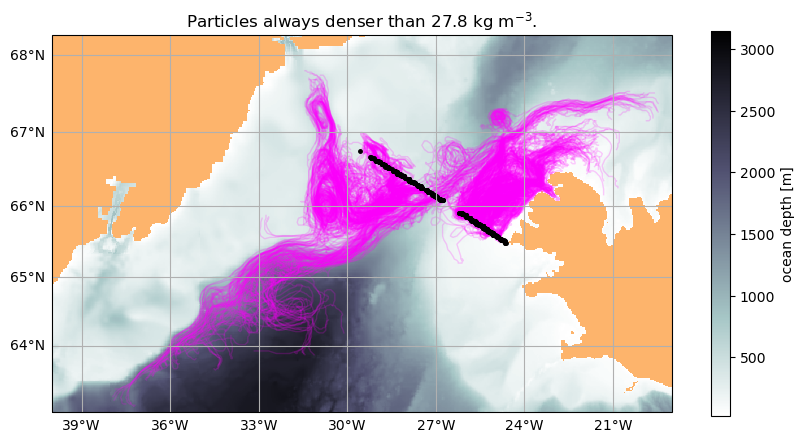

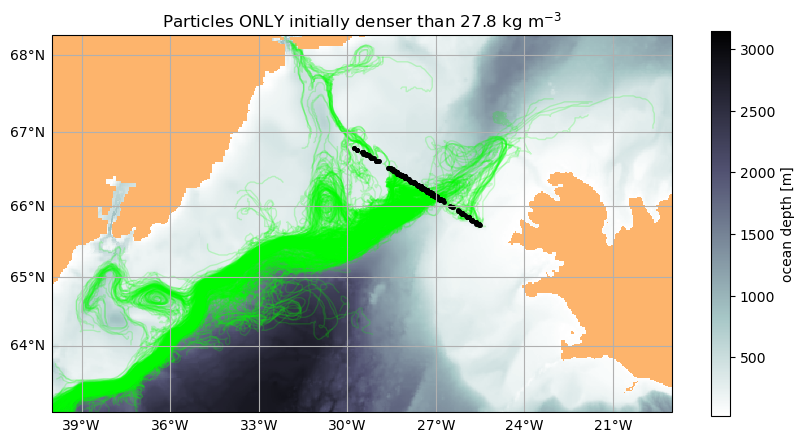

In [11]:
ods = [od_dense, od_mixed]
colors = ["fuchsia", "lime"]
titles = [
    r"Particles always denser than 27.8 kg m$^{-3}$.",
    r"Particles ONLY initially denser than 27.8 kg m$^{-3}$",
]
for _, (od_i, col, tit) in enumerate(zip(ods, colors, titles)):
    # Plot Depth
    fig = plt.figure(figsize=(10, 5))
    ax = od_eul.plot.horizontal_section(varName="masked_Depth", cmap="bone_r")
    land_col = (253 / 255, 180 / 255, 108 / 255)
    ax.patch.set_facecolor(land_col)
    ax.set_extent([-40, -19, 63, 68])

    # Plot trajectories
    ax.plot(
        od_i.dataset["XC"],
        od_i.dataset["YC"],
        color=col,
        alpha=0.2,
        linewidth=1,
        transform=PlateCarree(),
    )

    # Plot initial positions
    ax.plot(
        od_i.dataset["XC"].isel(time=0),
        od_i.dataset["YC"].isel(time=0),
        "k.",
        markersize=5,
        transform=PlateCarree(),
    )

    # Title
    _ = ax.set_title(tit)
    plt.show()

## TS-diagrams
We can use TS-diagrams to investigate the hydrographic properties of the `od_dense` and `od_mixed` sets.
For example, here we plot each `oceandataset` color-coded by particle depths separately (subplots a and b), then we plot them together on the same isopycnal contours (subplot c).

Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


/home/idies/mambaforge/envs/Oceanography/lib/python3.9/site-packages/oceanspy/plot.py:306: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(s.values, t.values, dens.values, **contour_kwargs)


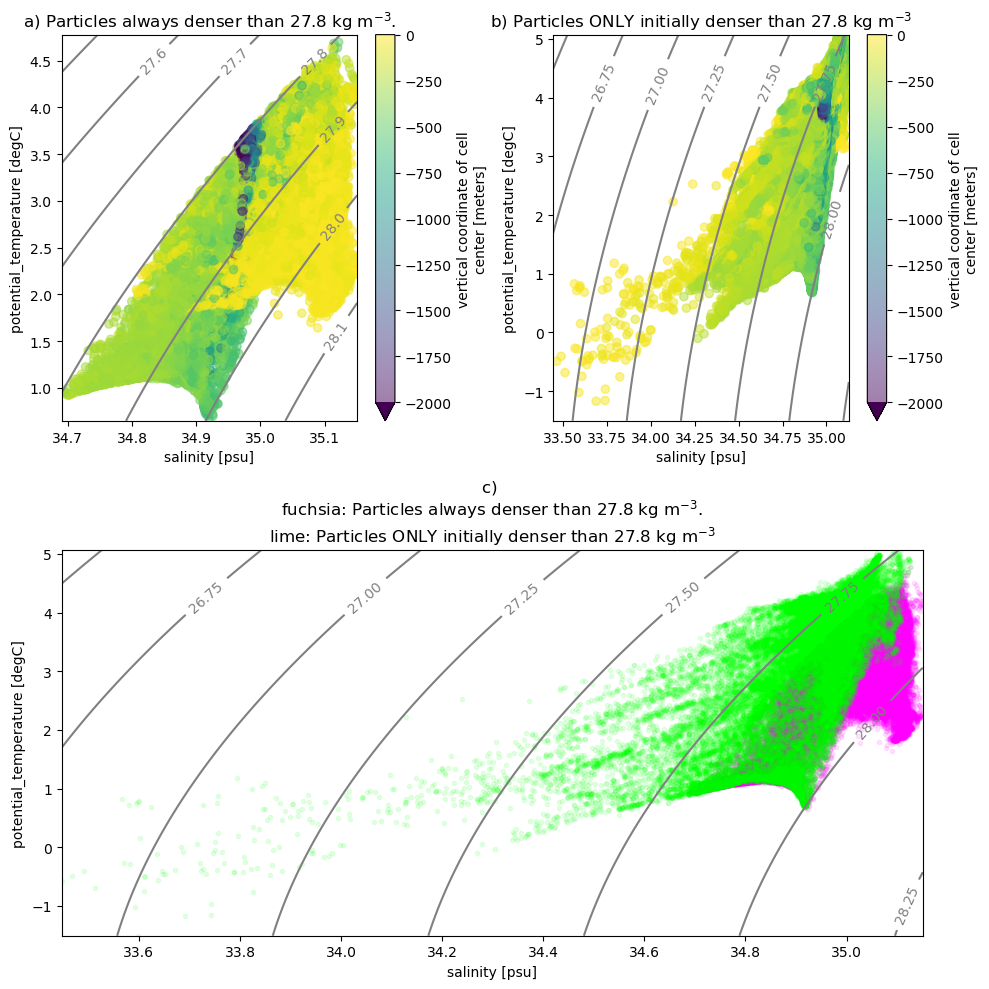

In [12]:
fig = plt.figure(figsize=(10, 10))

for i, (od_i, col, tit) in enumerate(zip(ods, colors, titles)):
    plt.subplot(int("22" + str(i + 1)))
    ax = od_i.plot.TS_diagram(
        colorName="Z", alpha=0.5, cmap_kwargs={"vmin": -2000, "vmax": 0}
    )
    ax.set_title(chr(ord("a") + i) + ") " + tit)

plt.subplot(212)
Tlim = [
    min([od_i.dataset["Temp"].min().values for od_i in ods]),
    max([od_i.dataset["Temp"].max().values for od_i in ods]),
]
Slim = [
    min([od_i.dataset["S"].min().values for od_i in ods]),
    max([od_i.dataset["S"].max().values for od_i in ods]),
]
for i, (od_i, col, tit) in enumerate(zip(ods, colors, titles)):
    contour_kwargs = {}
    if i == 0:
        contour_kwargs["levels"] = []
    ax = od_i.plot.TS_diagram(
        color=col,
        alpha=0.1,
        Tlim=Tlim,
        Slim=Slim,
        contour_kwargs=contour_kwargs,
    )
tit = "\n".join(
    ["c) "] + [f"{col}: {tit}" for _, (col, tit) in enumerate(zip(colors, titles))]
)
ax.set_title(tit)

plt.tight_layout()

## Time series
Now, we select 5 particles that were seeded in the overflow and became less dense along the path using the `od_mixed` set:

In [13]:
nparts = 5
step = np.ceil(len(od_mixed.dataset["particle"]) / 5)
od_5parts = ospy.OceanDataset(
    od_mixed.dataset.isel(particle=slice(None, None, int(step)))
)

Here is a plot of their trajectories:

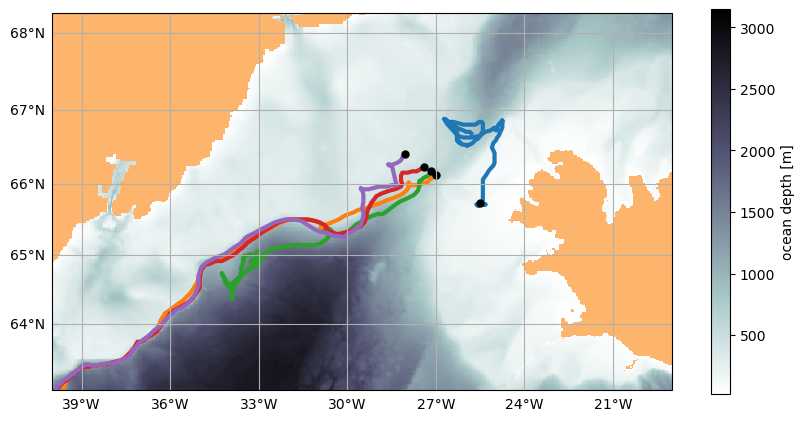

In [14]:
ods = [od_dense, od_mixed]
colors = ["fuchsia", "lime"]
titles = [
    r"Particles always denser than 27.8 kg m$^{-3}$.",
    r"Particles ONLY initially denser than 27.8 kg m$^{-3}$",
]

# Plot Depth
fig = plt.figure(figsize=(10, 5))
ax = od_eul.plot.horizontal_section(varName="masked_Depth", cmap="bone_r")
land_col = (253 / 255, 180 / 255, 108 / 255)
ax.patch.set_facecolor(land_col)
ax.set_extent([-40, -19, 63, 68])

# Plot trajectories
traj = ax.plot(
    od_5parts.dataset["XC"],
    od_5parts.dataset["YC"],
    linewidth=3,
    transform=PlateCarree(),
)

# Plot initial positions
i_pos = ax.plot(
    od_5parts.dataset["XC"].isel(time=0),
    od_5parts.dataset["YC"].isel(time=0),
    "k.",
    markersize=10,
    transform=PlateCarree(),
)

Now we plot the change in potential density anomaly as a function of time of these five particles (1st plot below), and the potential density anomaly gradient (2nd plot). The rapid decrease in particle density corresponds to intense mixing and entrainment of lighter ambient water as the overflow descends into the Irminger Sea. Notice one particle on the Iceland shelf (in blue) is not part of the overflow and moves north then mixes.

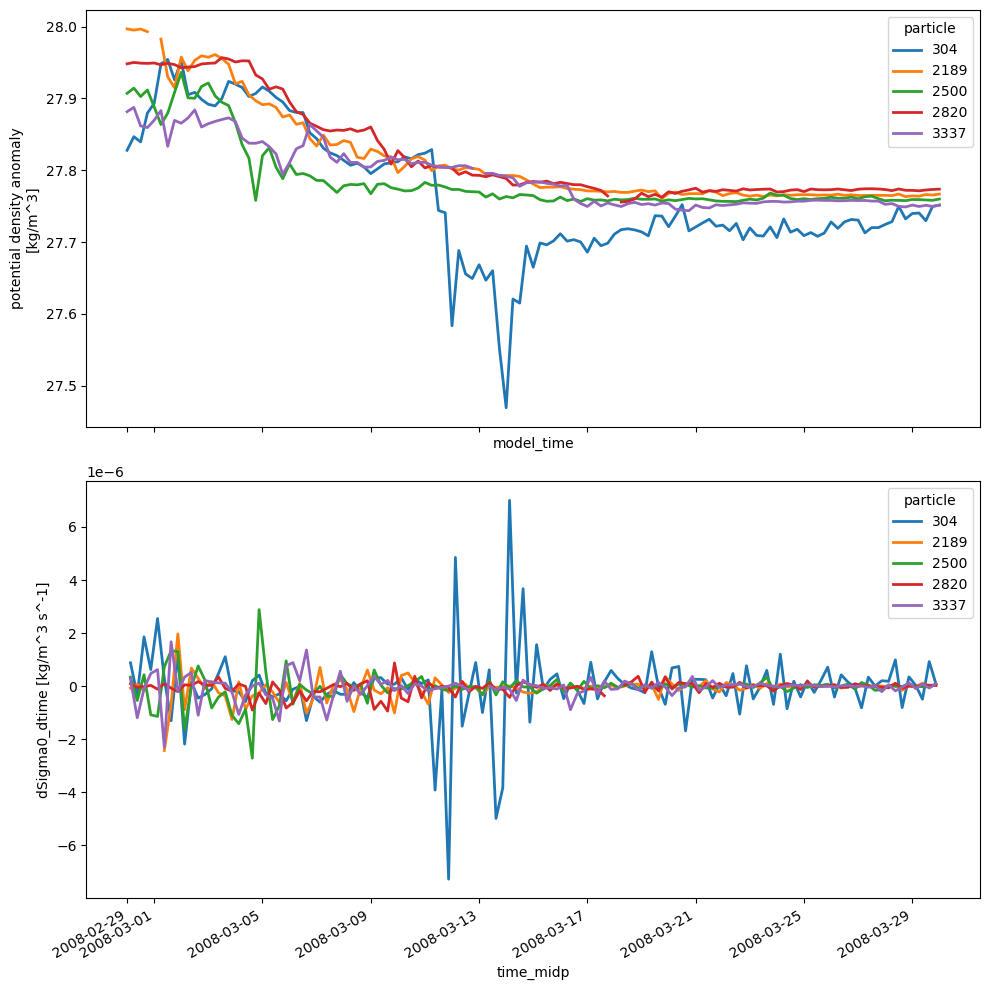

In [15]:
varName = "Sigma0"
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
for i, ax in enumerate(axes.flatten()):
    if i == 1:
        varName = f"d{varName}_dtime"
    ax = od_5parts.plot.time_series(varName=varName, ax=ax, linewidth=2)

The plots above can be easily customized for any of the extracted variables. 
For example, change `varName = 'Sigma0'` in the cell above with any of the variables printed below.

In [16]:
# Create table
table = {
    var: od_5parts.dataset[var].attrs.pop(
        "long_name", od_5parts.dataset[var].attrs.pop("description", None)
    )
    for var in od_5parts.dataset.variables
    if "time" not in var and "particle" not in var
}
print("\n{:>15}: {}\n".format("varName", "label"))
for name, desc in sorted(table.items()):
    print("{:>15}: {}".format(name, desc))


        varName: label

          Depth: ocean depth
              S: salinity
         Sigma0: potential density anomaly
           Temp: potential_temperature
             XC: longitude
             XG: longitude
             YC: latitude
             YG: latitude
              Z: vertical coordinate of cell center
             Zl: vertical coordinate of upper cell interface
            Zp1: vertical coordinate of cell interface
             Zu: vertical coordinate of lower cell interface
       momVort3: 3rd component (vertical) of Vorticity
